# Phishing Classification
This project meant for a binary classification task for (Spam/Not Spam) emails.

## Import Libraries

In [21]:
import plot_utils as pu
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

---
---
---

## Read Dataset

In [2]:
data = pd.read_csv('dataset_small.csv.xls')

In [3]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3598,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,...,1,4,1,3977,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,2,1,10788,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,1,2,1,14339,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,...,1,2,1,389,1,1,0,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 50.1 MB


This dataset contains 111 columns, that need to be discovered.

The target column called `Phishing`

---
---
---

## Data Cleansing

In [5]:
data.isna().sum().sum()

0

In [6]:
data.duplicated().sum()

1240

In [7]:
data.drop_duplicates(inplace=True)

---
---
---

## Check Cardinality

In [8]:
data.nunique()

qty_dot_url             23
qty_hyphen_url          30
qty_underline_url       22
qty_slash_url           25
qty_questionmark_url     6
                        ..
qty_redirects           15
url_google_index         3
domain_google_index      3
url_shortened            2
phishing                 2
Length: 112, dtype: int64

In [9]:
# Drop any features with higher than 5 unique values
threshold = 5
filtered_columns = data.columns[data.nunique() <= threshold]
filtered_data = data[filtered_columns]
filtered_data.nunique()

qty_underline_domain          3
qty_slash_domain              1
qty_questionmark_domain       1
qty_equal_domain              1
qty_at_domain                 2
qty_and_domain                1
qty_exclamation_domain        1
qty_space_domain              1
qty_tilde_domain              1
qty_comma_domain              1
qty_plus_domain               1
qty_asterisk_domain           1
qty_hashtag_domain            1
qty_dollar_domain             1
qty_percent_domain            1
domain_in_ip                  2
server_client_domain          2
qty_questionmark_directory    2
qty_comma_directory           5
qty_hashtag_directory         2
qty_slash_file                2
qty_questionmark_file         2
qty_equal_file                5
qty_at_file                   4
qty_and_file                  5
qty_exclamation_file          5
qty_hashtag_file              2
qty_dollar_file               2
qty_space_params              4
qty_tilde_params              3
qty_asterisk_params           4
qty_hash

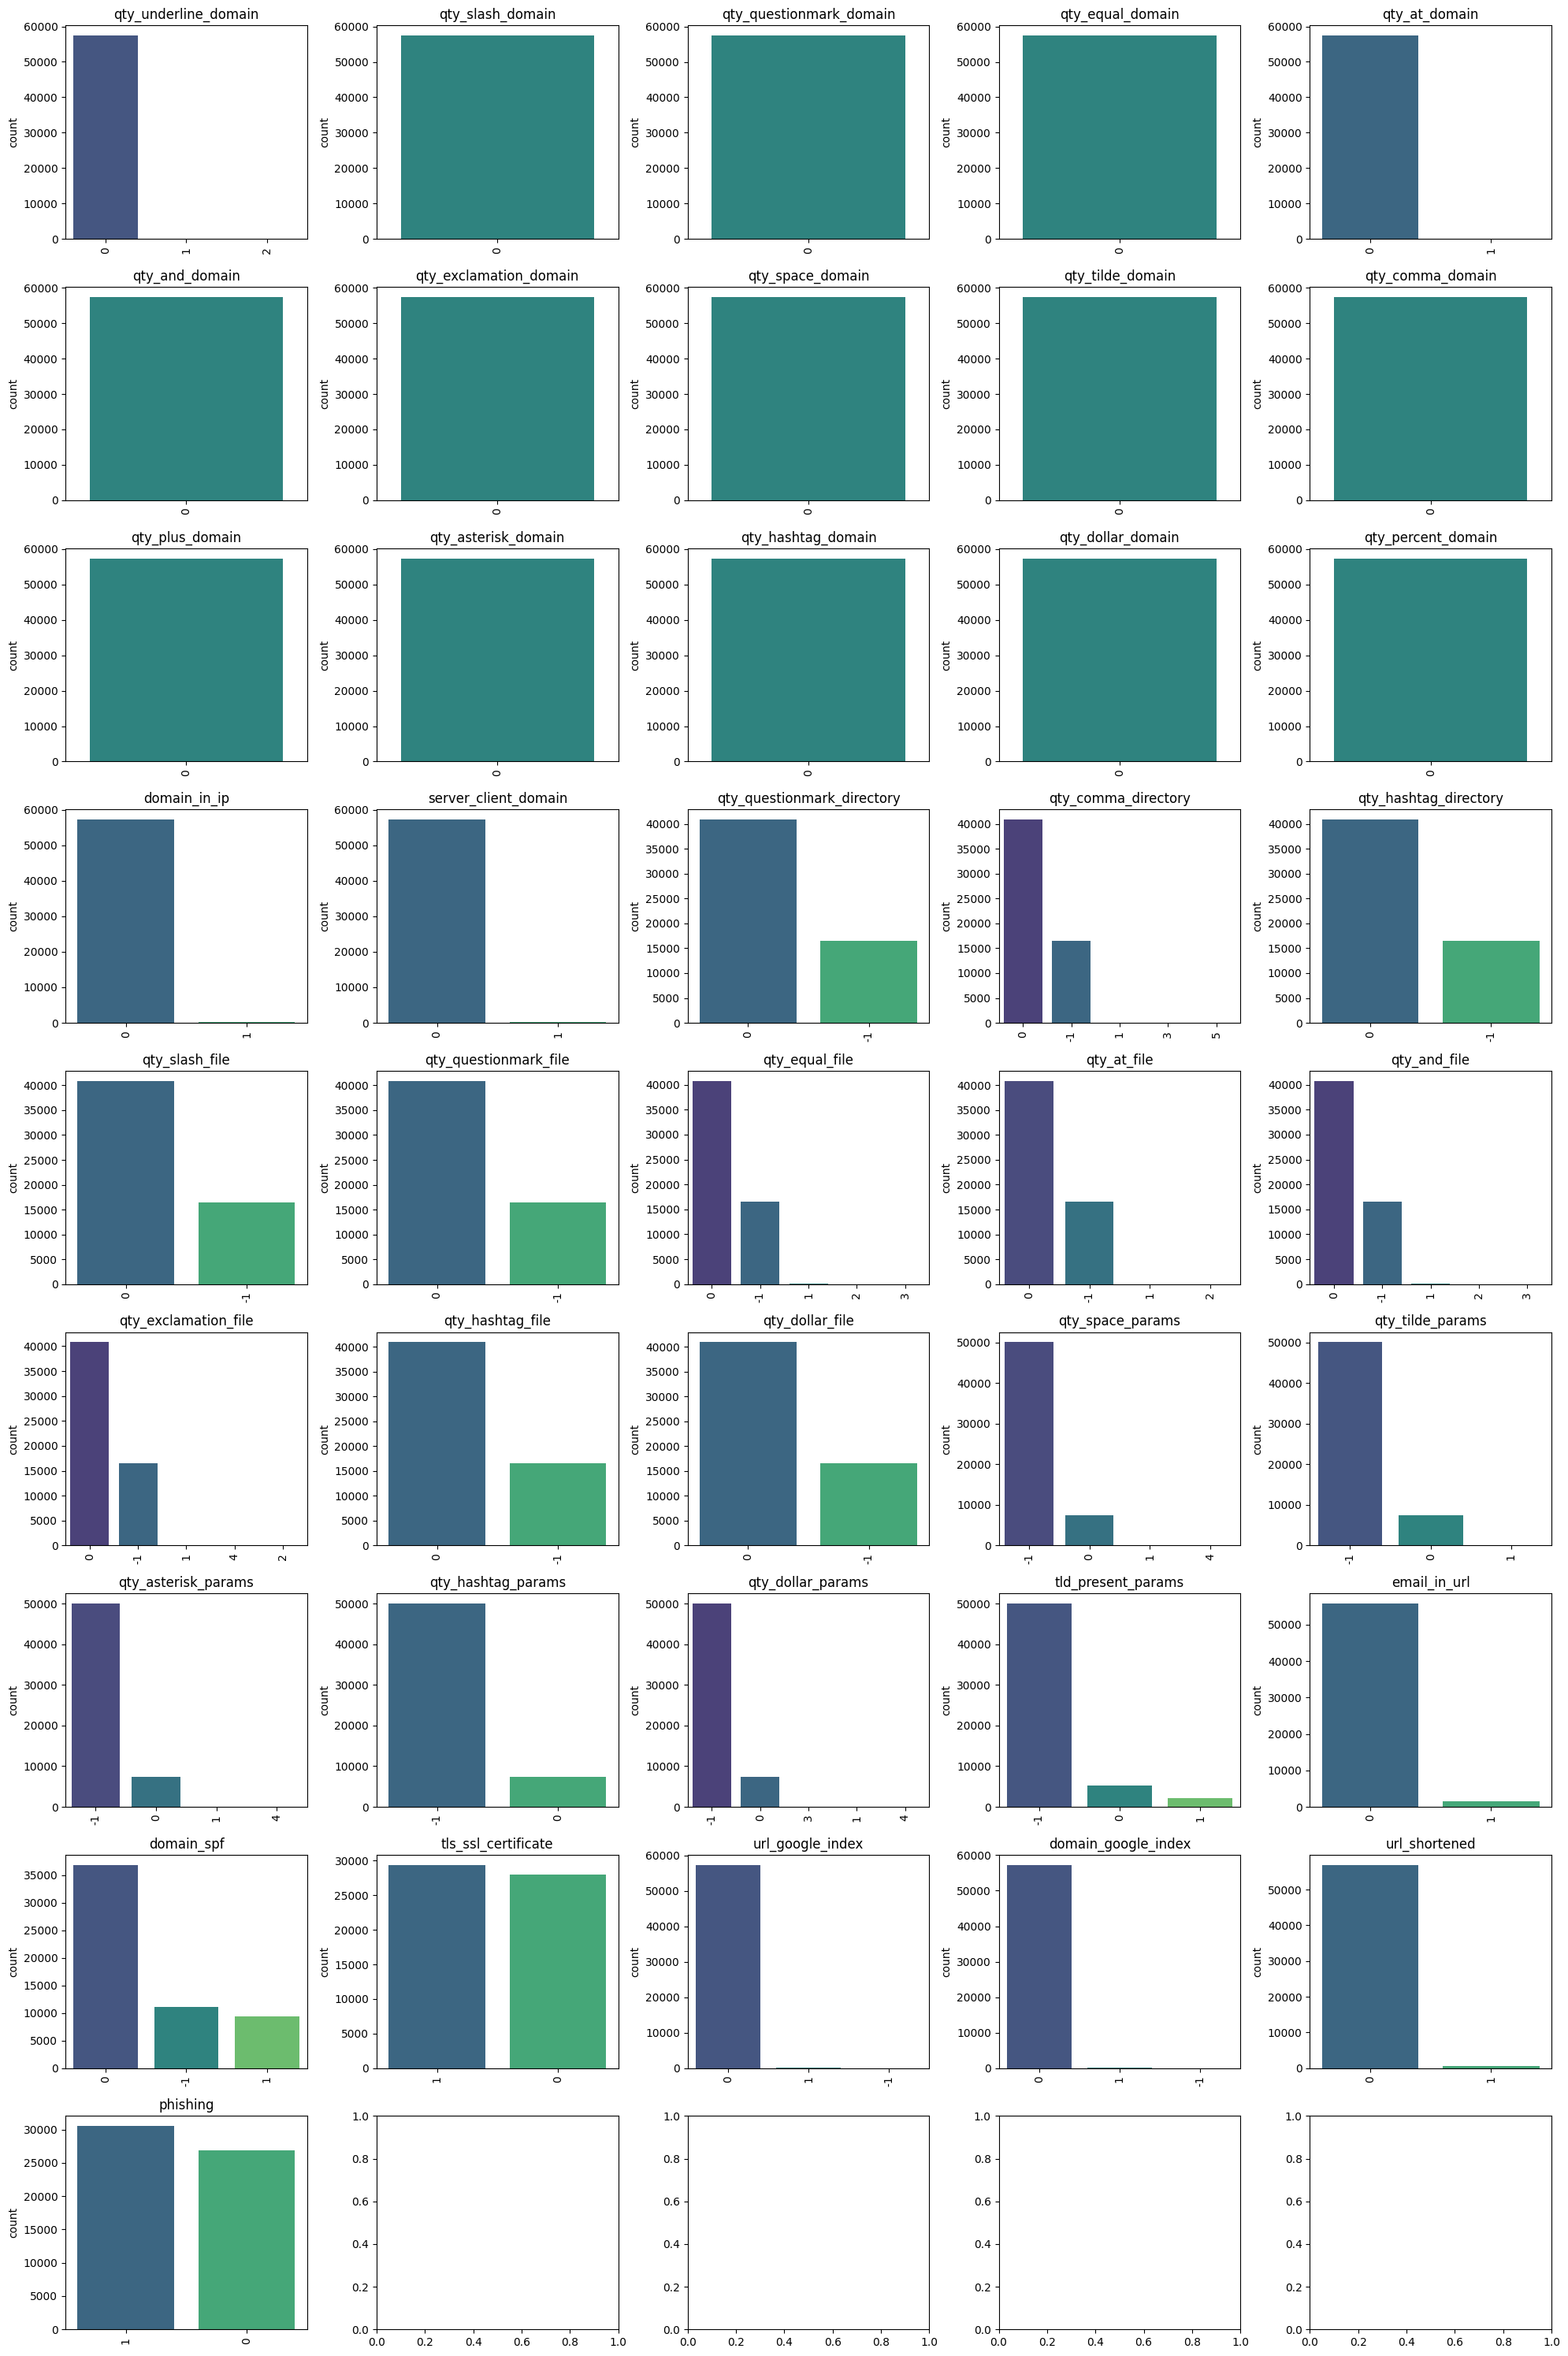

In [10]:
# display features distribution
pu.display_value_counts_with_order(filtered_data, filtered_data.columns, 5)

---
---
---

## Feature Engineering

In [11]:
# Drop features with only zeros as value.
filtered_data = filtered_data.loc[:, (filtered_data != 0).any(axis=0)]

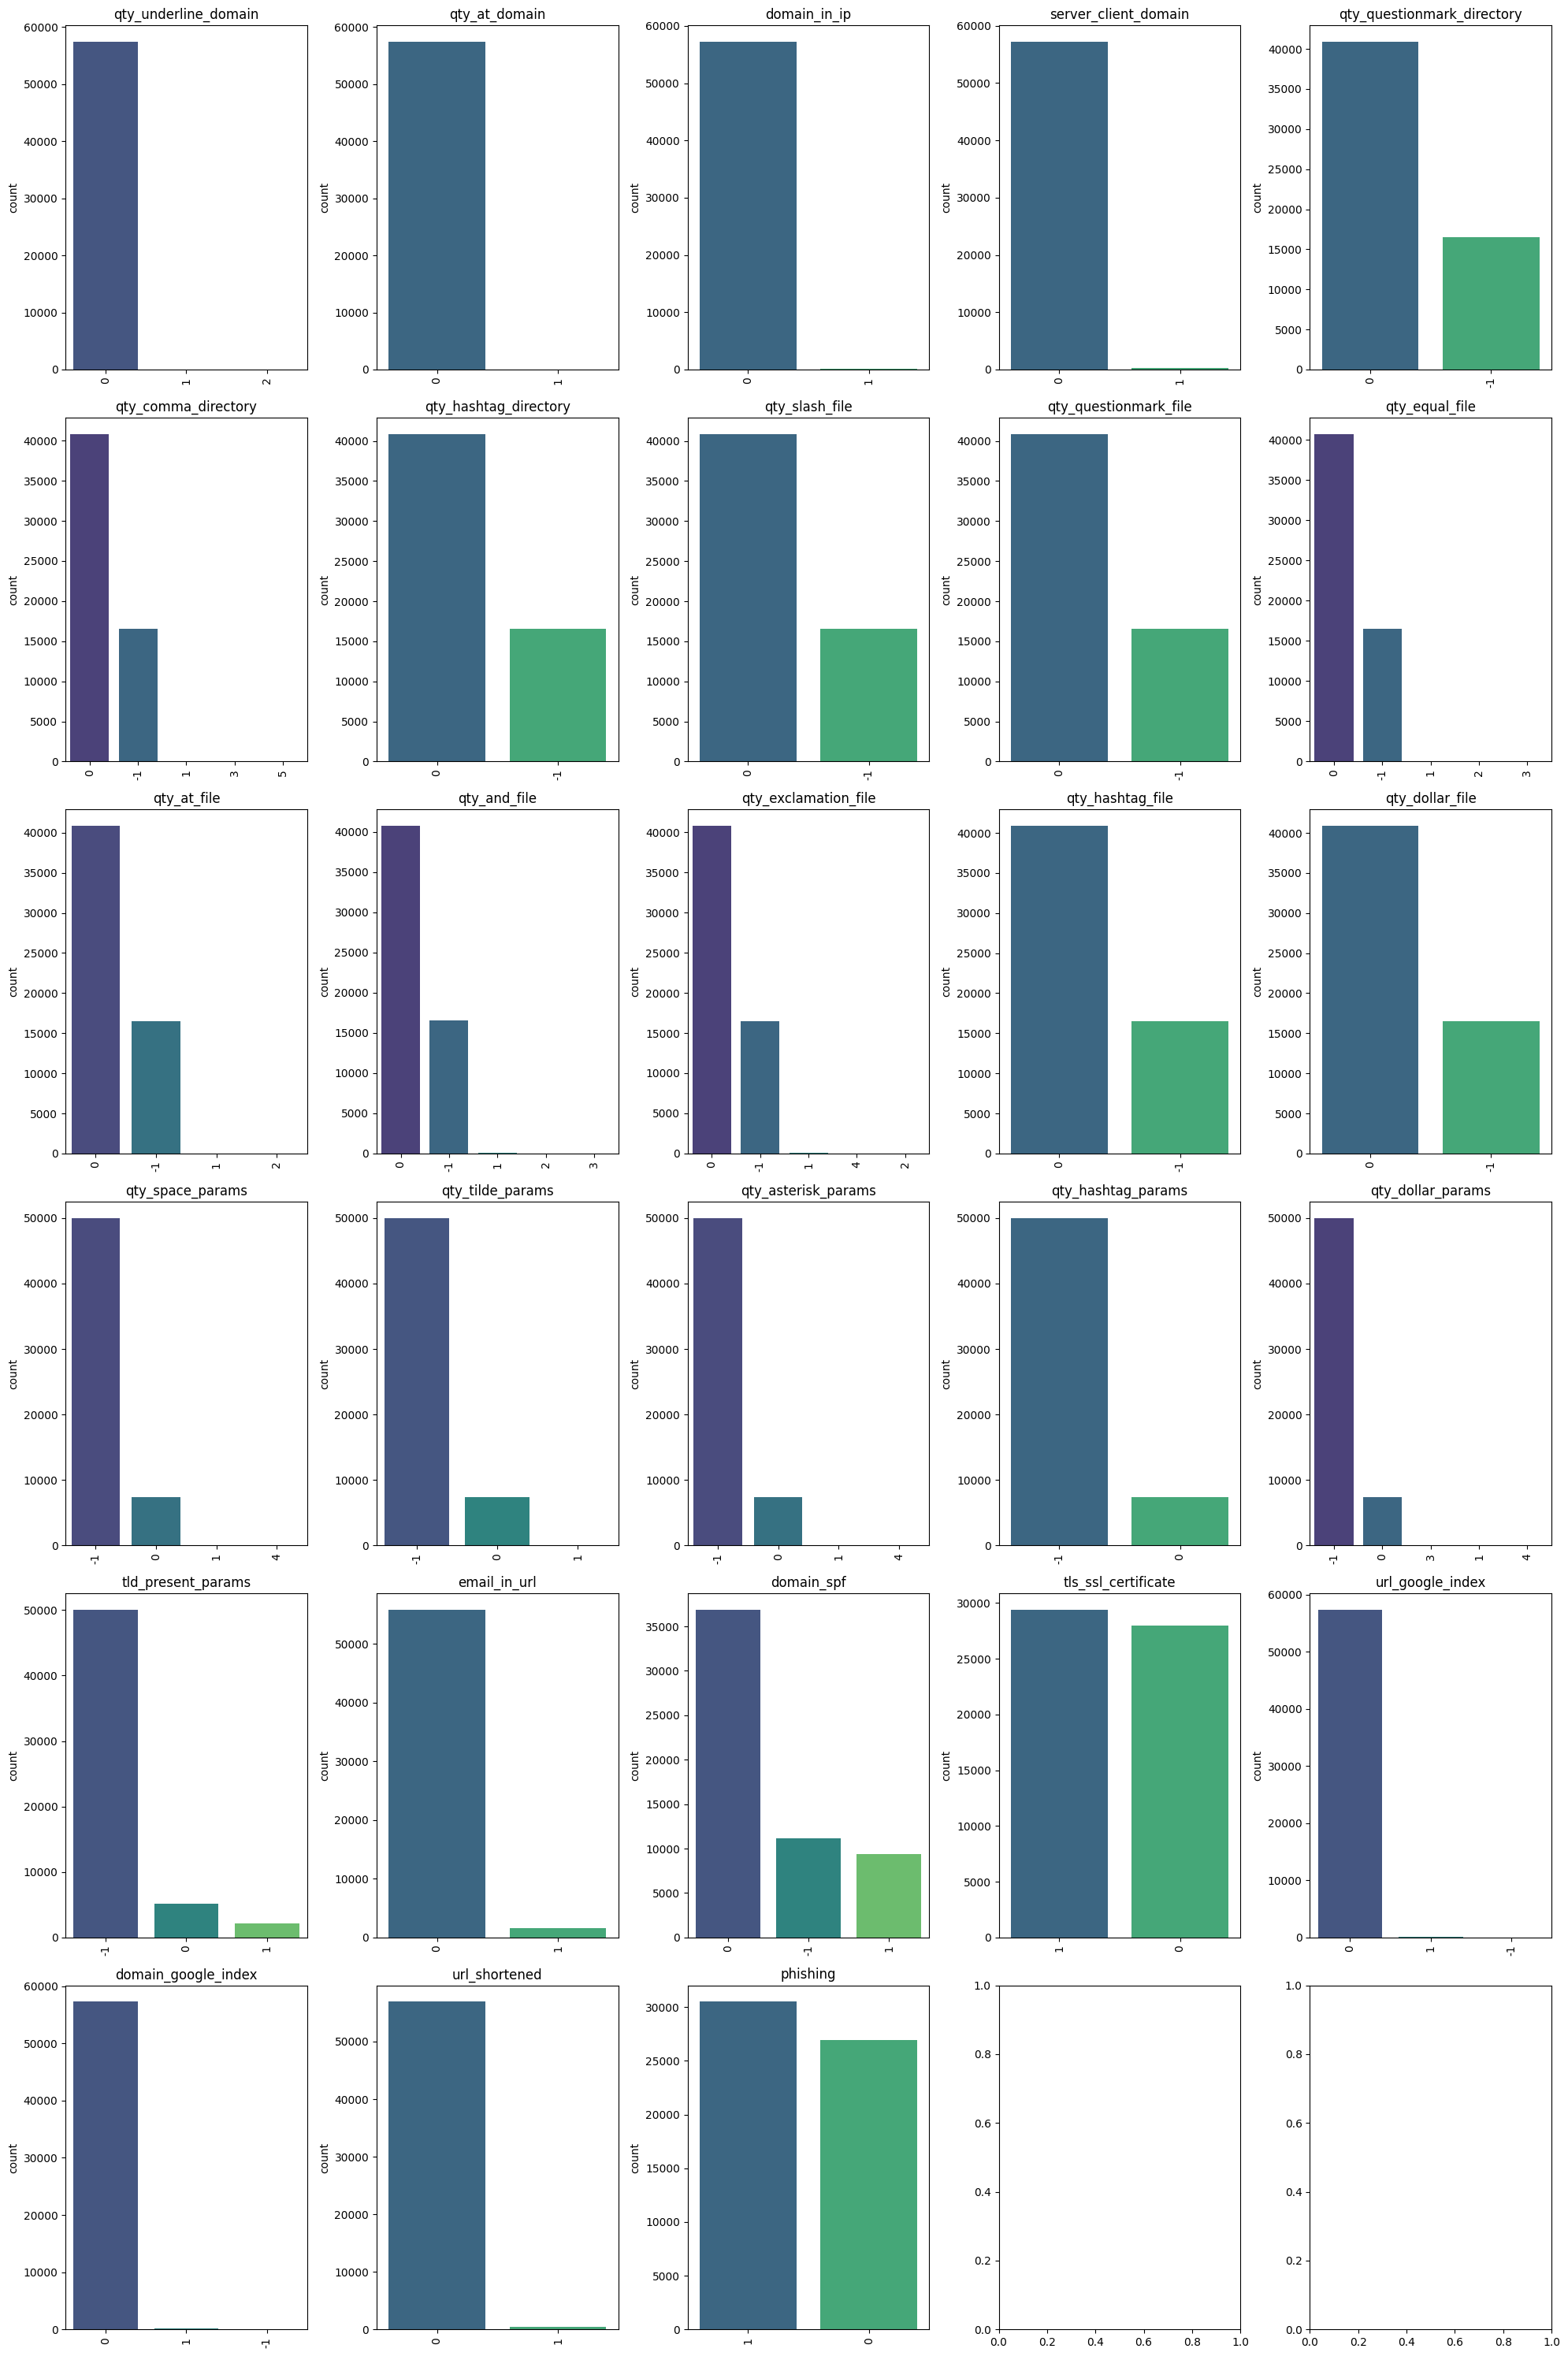

In [12]:
pu.display_value_counts_with_order(filtered_data, filtered_data.columns, 5)

---
---
---

## Data Imbalance

In [13]:
# Drop any feature that biased by 80% to a single value.
threshold = 0.8
value_counts = filtered_data.apply(lambda x: x.value_counts(normalize=True).max())
filtered_columns = value_counts[value_counts <= threshold].index
final_filtered_data = filtered_data[filtered_columns]

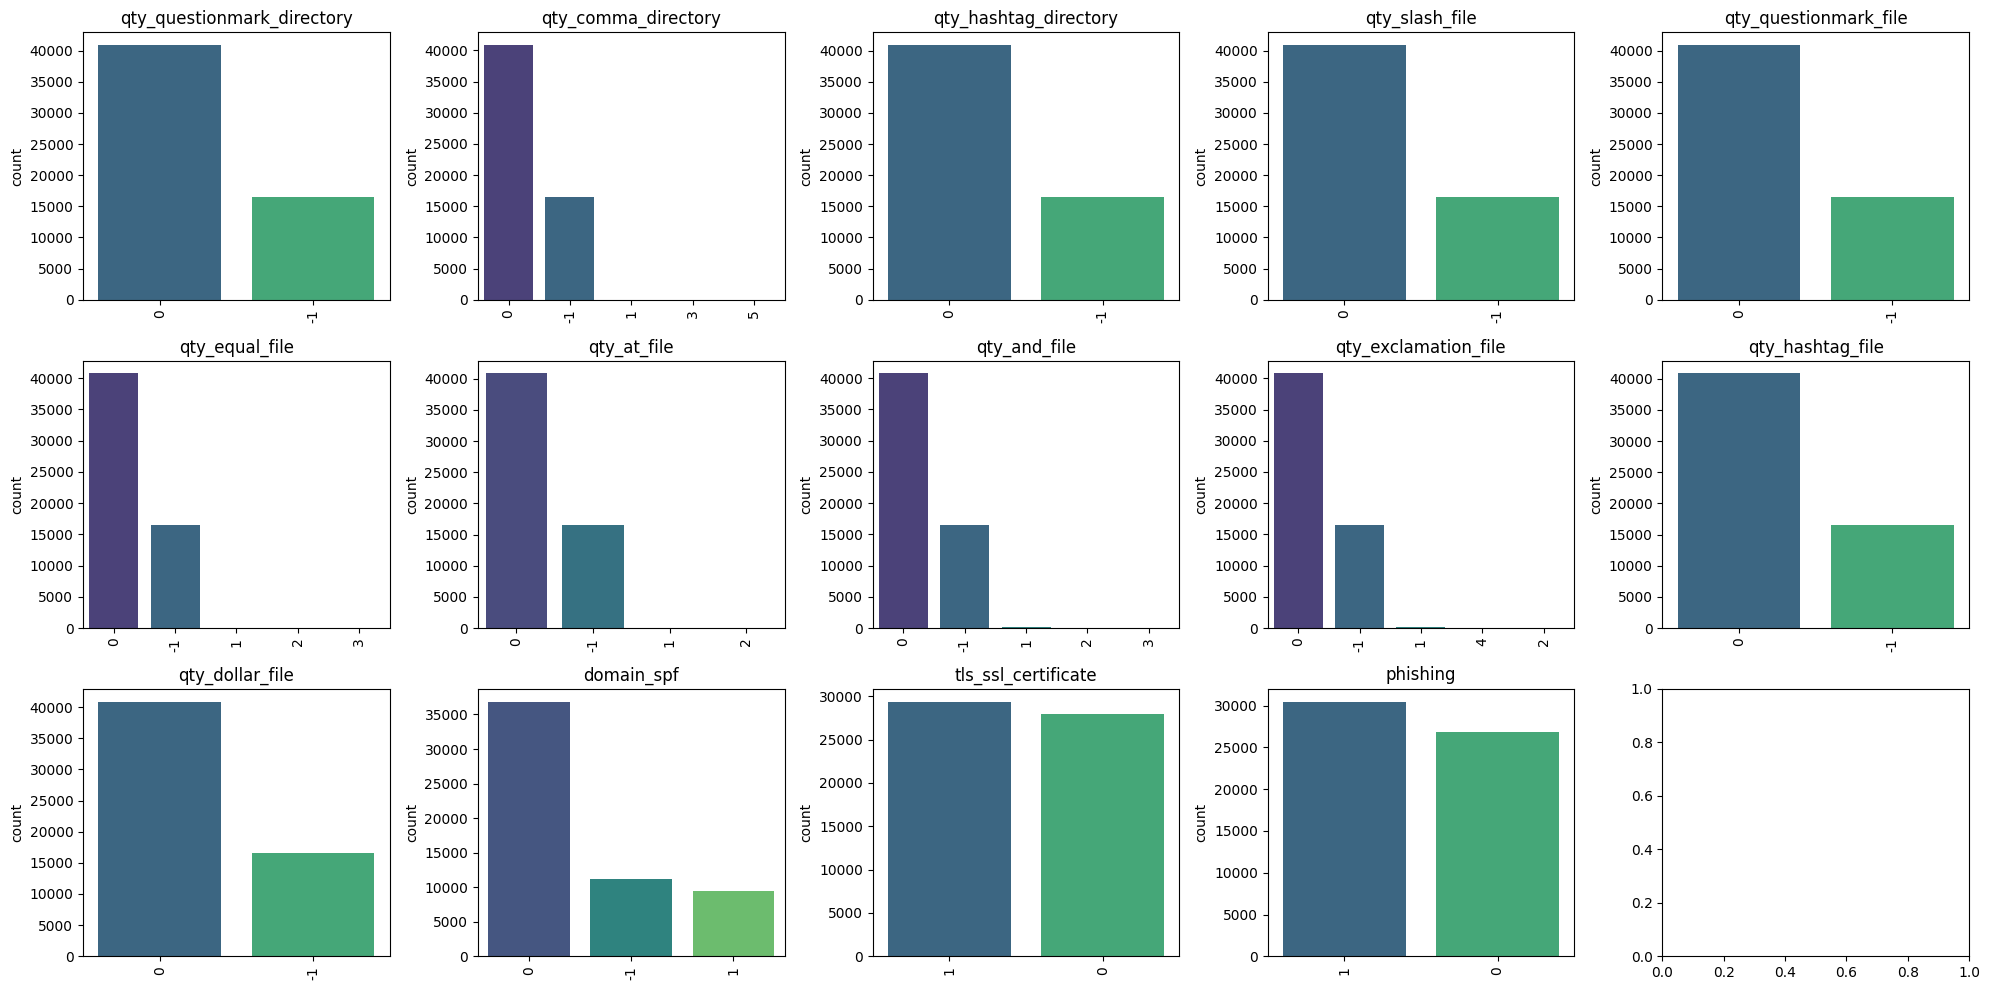

In [14]:
pu.display_value_counts_with_order(final_filtered_data, final_filtered_data.columns, 5, (20, 10))

---
---
---

## Data Correlation

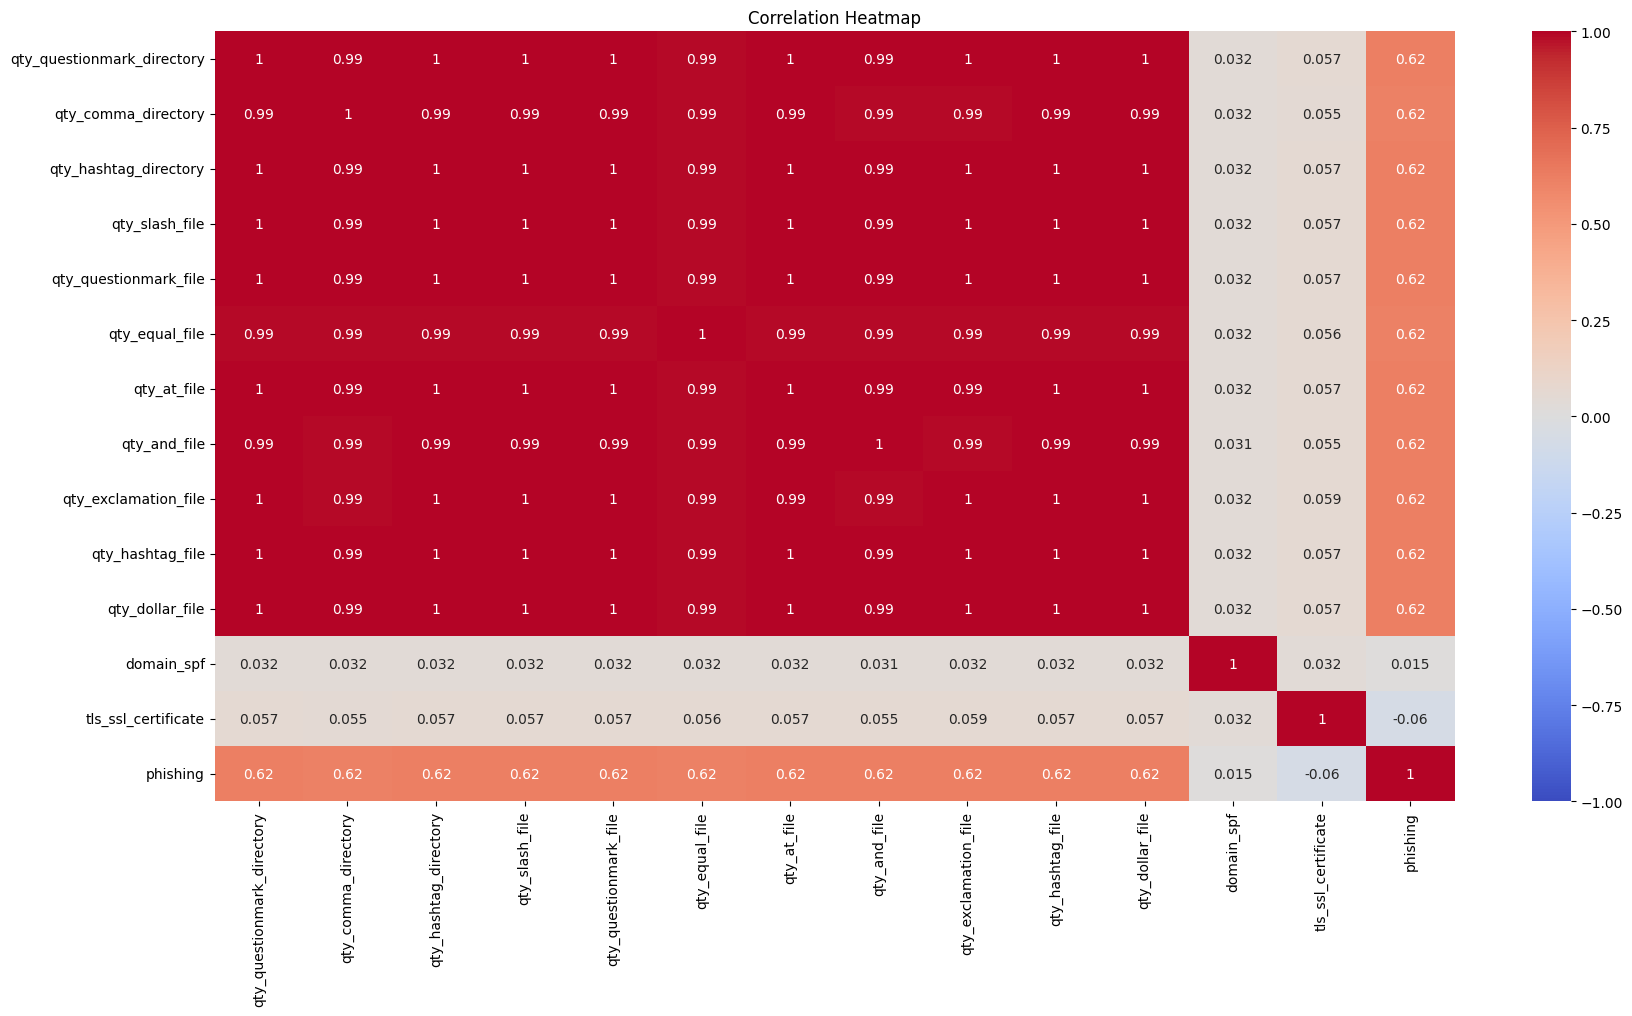

In [15]:
pu.display_correlation(final_filtered_data, 'pearson')

---
---
---

## Feature Selection

In [16]:
# Drop features with high correlation, and keep only features with higher correlation to the target.
threshold = 0.9
correlation_matrix = final_filtered_data.corr()
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

for feature1, feature2 in highly_correlated_pairs:
    if feature1 in final_filtered_data.columns and feature2 in final_filtered_data.columns:
        corr_target_feature1 = final_filtered_data[feature1].corr(final_filtered_data['phishing'])
        corr_target_feature2 = final_filtered_data[feature2].corr(final_filtered_data['phishing'])

        if corr_target_feature1 < corr_target_feature2:
            final_filtered_data = final_filtered_data.drop(columns=[feature1])
        else:
            final_filtered_data = final_filtered_data.drop(columns=[feature2])

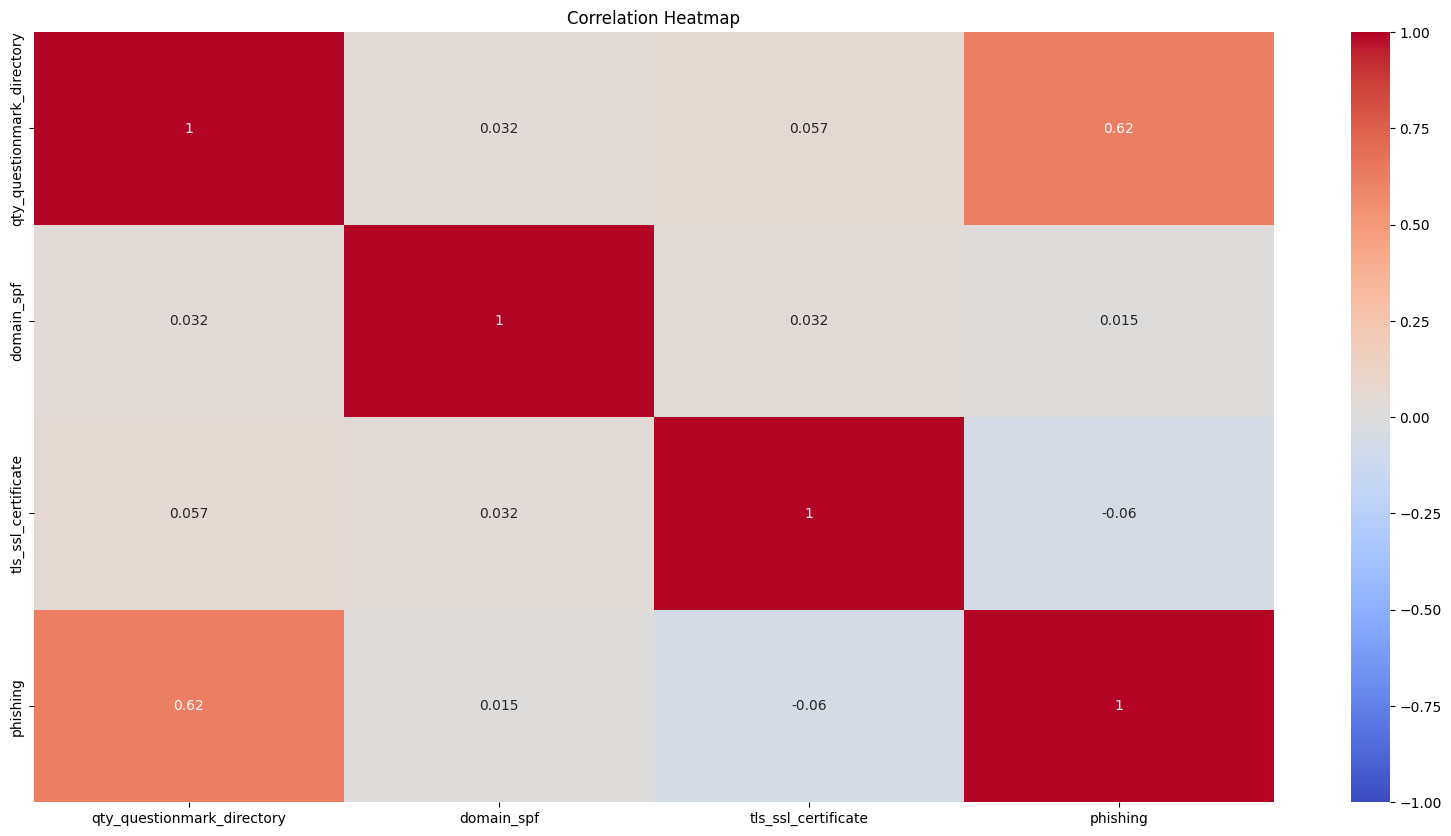

In [17]:
pu.display_correlation(final_filtered_data, 'pearson')

---
---
---

## Split Dataset to Train & Test

In [18]:
# Split data to X and y
X = final_filtered_data.drop(columns=['phishing'])
y = final_filtered_data['phishing']

# Standardize the data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify=y, random_state=42)

---
---
---

## SVM for Classification

In [19]:
# define hyper-parameters
svm_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# use gridsearch for hyper-parameter tuning
svm_classifier = SVC(random_state=42)
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)

# evaluate model
svm_predictions = svm_grid_search.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

print("Best Parameters for SVM:", svm_grid_search.best_params_)
print("SVM Accuracy:", svm_accuracy)
print("Classification Report (SVM):\n", classification_report(y_test, svm_predictions))

Best Parameters for SVM: {'C': 0.001, 'kernel': 'linear'}
SVM Accuracy: 0.7904363731382283
Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.96      0.58      0.72      5382
           1       0.72      0.98      0.83      6099

    accuracy                           0.79     11481
   macro avg       0.84      0.78      0.78     11481
weighted avg       0.83      0.79      0.78     11481



---
---
---

## Logistic Regression for Classification

In [20]:
# define hyper-parameters
logistic_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# use gridsearch for hyper-parameter tuning
logistic_regression_classifier = LogisticRegression(solver='liblinear', max_iter=5000, random_state=42)
logistic_grid_search = GridSearchCV(logistic_regression_classifier, logistic_param_grid, cv=5)
logistic_grid_search.fit(X_train, y_train)

# evaluate model
logistic_regression_predictions = logistic_grid_search.predict(X_test)
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)

print("Best Parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Logistic Regression Accuracy:", logistic_regression_accuracy)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, logistic_regression_predictions))

Best Parameters for Logistic Regression: {'C': 0.001, 'penalty': 'l1'}
Logistic Regression Accuracy: 0.7904363731382283
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.96      0.58      0.72      5382
           1       0.72      0.98      0.83      6099

    accuracy                           0.79     11481
   macro avg       0.84      0.78      0.78     11481
weighted avg       0.83      0.79      0.78     11481



## XGBoost for Classification

In [24]:
# define hyper-parameters
xgboost_param_grid = {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [25, 50, 100, 200]}

# use gridsearch for hyper-parameter tuning
xgboost_classifier = XGBClassifier(random_state=42)
xgboost_grid_search = GridSearchCV(xgboost_classifier, xgboost_param_grid, cv=5)
xgboost_grid_search.fit(X_train, y_train)

# Evaluate XGBoost
xgboost_predictions = xgboost_grid_search.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

print("\nBest Parameters for XGBoost:", xgboost_grid_search.best_params_)
print("XGBoost Accuracy:", xgboost_accuracy)
print("Classification Report (XGBoost):\n", classification_report(y_test, xgboost_predictions))


Best Parameters for XGBoost: {'learning_rate': 0.01, 'n_estimators': 25}
XGBoost Accuracy: 0.7904363731382283
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.96      0.58      0.72      5382
           1       0.72      0.98      0.83      6099

    accuracy                           0.79     11481
   macro avg       0.84      0.78      0.78     11481
weighted avg       0.83      0.79      0.78     11481

